In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy import stats

## Balck-Scholes formulas

In [2]:
def d1_d2(K, r, sigma, T, X, t):
    d1 = (np.log(X / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return d1, d2

def payoff(X, K, option_type = 'Call'):
    if option_type == 'Call':
        f_t = np.maximum(X - K, 0)
    if option_type == 'Put':
        f_t = np.maximum(K - X, 0)
    return f_t

def black_scholes_price(K, r, sigma, T, X, t, option_type):
    d1, d2 = d1_d2(K, r, sigma, T, X, t)
    if option_type == 'Call':
        price = X * stats.norm.cdf(d1) - K * np.exp(-r * (T - t)) * stats.norm.cdf(d2)
    if option_type == 'Put':
        price = K * np.exp(-r * (T - t)) * stats.norm.cdf(-d2) - X * stats.norm.cdf(- d1)
    return price

# European options

In [3]:
def european_option_price_MC(S_0, K, r, sigma, T, N, option_type):
    z = np.random.normal(0, 1, N)
    ST = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    payoffs = payoff(ST, K, option_type)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

def european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, N, option_type):
    z1 = np.random.normal(0, 1, N//2)
    z2 = -z1
    ST_1 = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z1)
    ST_2 = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z2)
    payoffs = 0.5 * (payoff(ST_1, K, option_type) + payoff(ST_2, K, option_type))
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

def european_option_price_MC_control_variate(S_0, K, r, sigma, T, N, option_type):
    # PILOT paths for estimation of variance od control varince and expected value of control variable
    z_pilot = np.random.normal(0, 1, 1000)
    ST_pilot = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z_pilot)
    control_variate_pilot = ST_pilot
    control_variate_expected_value = S_0 * np.exp(r*T)
    payoffs_pilot = payoff(ST_pilot, K, option_type)
    covariance = np.cov(payoffs_pilot, control_variate_pilot)
    c = - covariance[1,0] / covariance[1,1]

    z = np.random.normal(0, 1, N)
    ST = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    control_variate = ST
    payoffs = payoff(ST, K, option_type)
    adjusted_payoffs = payoffs + c * (control_variate - control_variate_expected_value)
    option_price = np.exp(-r * T) * np.mean(adjusted_payoffs)
    return option_price

def european_option_price_QMC(S_0, K, r, sigma, T, N, option_type, sequence_type):
    if sequence_type == 'Halton':
        halton_sample = stats.qmc.Halton(d = 1, scramble = True).random(n = N)
        z = stats.norm.ppf(halton_sample)
    elif sequence_type == 'Sobol':
        halton_sample = stats.qmc.Sobol(d = 1, scramble = True).random(n = N)
        z = stats.norm.ppf(halton_sample)      
    else:
        raise ValueError("Invalid sequence_type. Use 'Halton' or 'Sobol'.")
    ST = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    payoffs = payoff(ST, K, option_type)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

def european_option_variance(S_0, K, r, sigma, T, N, option_type):
    prices = [european_option_price_MC(S_0, K, r, sigma, T, N, option_type)
                                          for _ in range(200)]
    variance = np.var(prices)
    return variance

def european_option_variance_antithetic_variate(S_0, K, r, sigma, T, N, option_type):
    prices = np.array([european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, N, option_type)
                                          for _ in range(200)])
    variance = np.var(prices)
    return variance

def european_option_variance_halton(S_0, K, r, sigma, T, N, option_type):
    prices = np.array([european_option_price_QMC(S_0, K, r, sigma, T, N, option_type, 'Halton')
                                          for _ in range(200)])
    variance = np.var(prices)
    return variance

def european_option_variance_sobol(S_0, K, r, sigma, T, N, option_type):
    prices = np.array([european_option_price_QMC(S_0, K, r, sigma, T, N, option_type, 'Sobol')
                                          for _ in range(200)])
    variance = np.var(prices)
    return variance

In [4]:
N_min = 500
interval = 300
N_max = 50000 + interval
S_0 = 100
K = 100
T = 1
k = T*252
sigma = 0.2
r = 0.05

In [5]:
BS_call_theo = black_scholes_price(S_0, r, sigma, T, K, 0, 'Call')
BS_put_theo = black_scholes_price(S_0, r, sigma, T, K, 0, 'Put')
numbers_of_steps = list(range(N_min, N_max, interval))

In [6]:
%%time
european_put_prices_MC_antithetic_variate = [european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, i, 'Put') for i in numbers_of_steps]
european_call_prices_MC_antithetic_variate = [european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, i, 'Call') for i in numbers_of_steps]

Wall time: 593 ms


In [8]:
%%time
european_put_prices_QMC_Halton = [european_option_price_QMC(S_0, K, r, sigma, T, i, 'Put', 'Halton')
                                              for i in numbers_of_steps]
european_call_prices_QMC_Halton = [european_option_price_QMC(S_0, K, r, sigma, T, i, 'Call', 'Halton')
                                                for i in numbers_of_steps]
european_put_prices_QMC_Sobol = [european_option_price_QMC(S_0, K, r, sigma, T, i, 'Put', 'Sobol')
                                              for i in numbers_of_steps]
european_call_prices_QMC_Sobol = [european_option_price_QMC(S_0, K, r, sigma, T, i, 'Call', 'Sobol')
                                                for i in numbers_of_steps]

Wall time: 14.2 s


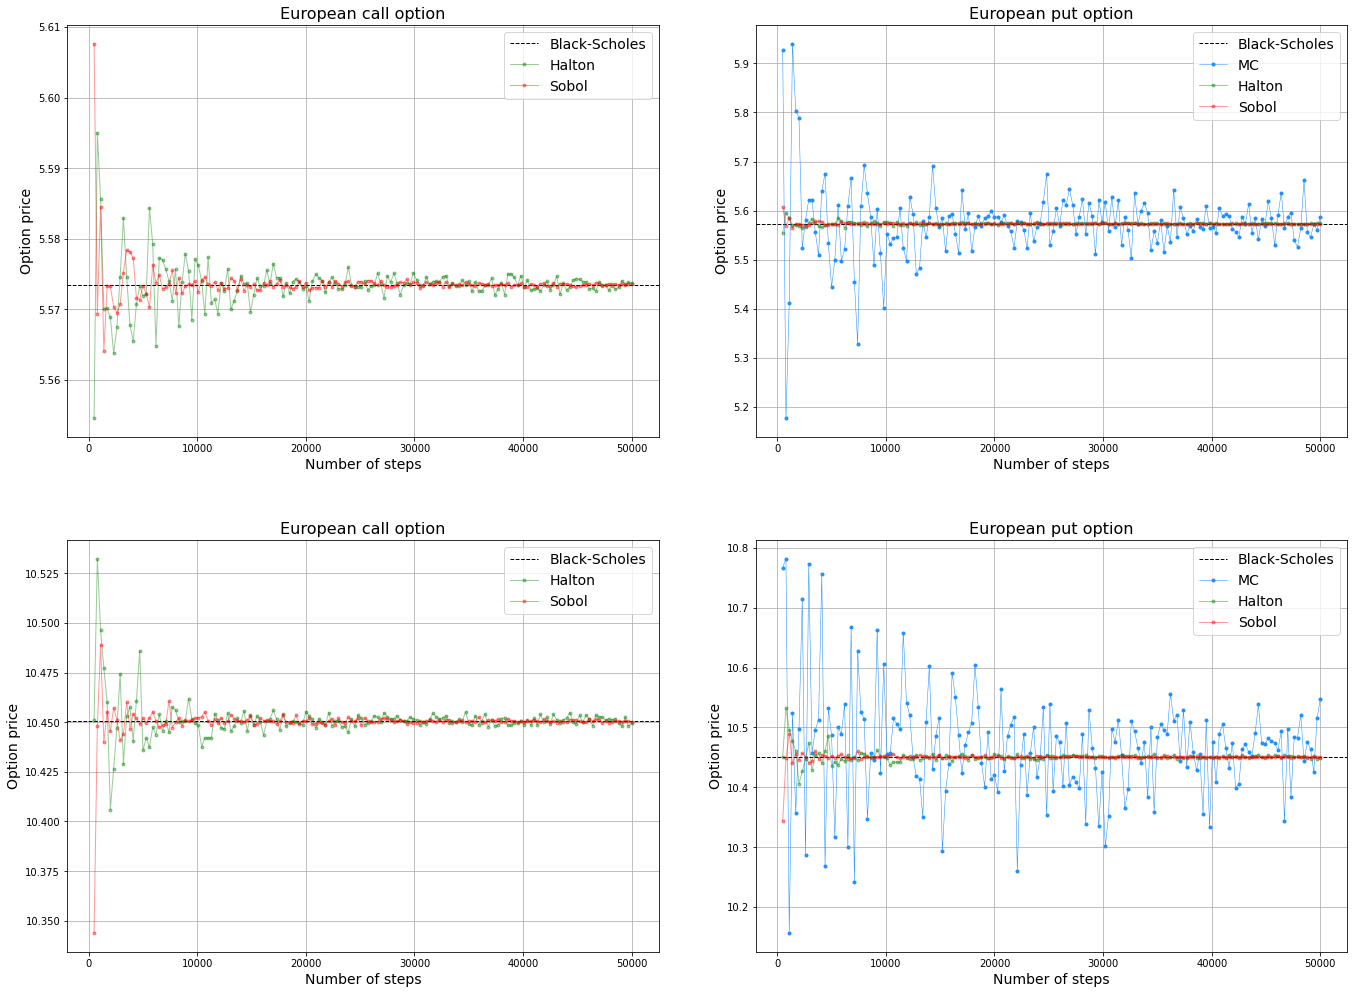

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
#fig.suptitle("European options", fontsize = 22)
axes[0,0].grid()
axes[0,0].axhline(BS_put_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[0,0].plot(numbers_of_steps, european_put_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[0,0].plot(numbers_of_steps, european_put_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[0,0].legend(fontsize = 14)
axes[0,0].set_title('European call option', fontsize = 16)
axes[0,0].set_ylabel('Option price', fontsize = 14)
axes[0,0].set_xlabel('Number of steps', fontsize = 14)
axes[1,0].grid()
axes[1,0].axhline(BS_call_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[1,0].plot(numbers_of_steps, european_call_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[1,0].plot(numbers_of_steps, european_call_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[1,0].legend(fontsize = 14)
axes[1,0].set_title('European call option', fontsize = 16)
axes[1,0].set_ylabel('Option price', fontsize = 14)
axes[1,0].set_xlabel('Number of steps', fontsize = 14)
axes[0,1].grid()
axes[0,1].axhline(BS_put_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[0,1].plot(numbers_of_steps, european_put_prices_MC_antithetic_variate, lw = 0.5, color = 'dodgerblue', label = 'MC', marker = '.')
axes[0,1].plot(numbers_of_steps, european_put_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[0,1].plot(numbers_of_steps, european_put_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[0,1].legend(fontsize = 14)
axes[0,1].set_title('European put option', fontsize = 16)
axes[0,1].set_ylabel('Option price', fontsize = 14)
axes[0,1].set_xlabel('Number of steps', fontsize = 14)
axes[1,1].grid()
axes[1,1].axhline(BS_call_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[1,1].plot(numbers_of_steps, european_call_prices_MC_antithetic_variate, lw = 0.5, color = 'dodgerblue', label = 'MC', marker = '.')
axes[1,1].plot(numbers_of_steps, european_call_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[1,1].plot(numbers_of_steps, european_call_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[1,1].legend(fontsize = 14)
axes[1,1].set_title('European put option', fontsize = 16)
axes[1,1].set_ylabel('Option price', fontsize = 14)
axes[1,1].set_xlabel('Number of steps', fontsize = 14)
plt.tight_layout(pad = 5)
#plt.show()
plt.savefig("European_options_halton_sobol_MC.png", dpi = 300)

In [26]:
%%time
european_put_prices_MC_antithetic_variate_hist = [european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, 10000, 'Put')
                                          for _ in range(1000)]
european_call_prices_MC_antithetic_variate_hist = [european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, 10000, 'Call') 
                                            for _ in range(1000)]
european_put_prices_QMC_halton_hist = [european_option_price_QMC(S_0, K, r, sigma, T, 10000, 'Put', 'Halton') 
                                          for _ in range(1000)]
european_call_prices_QMC_halton_hist = [european_option_price_QMC(S_0, K, r, sigma, T, 10000, 'Call', 'Halton')
                                            for _ in range(1000)]
european_put_prices_QMC_sobol_hist = [european_option_price_QMC(S_0, K, r, sigma, T, 10000, 'Put', 'Sobol') 
                                          for _ in range(1000)]
european_call_prices_QMC_sobol_hist = [european_option_price_QMC(S_0, K, r, sigma, T, 10000, 'Call', 'Sobol')
                                            for _ in range(1000)]

Wall time: 38.3 s


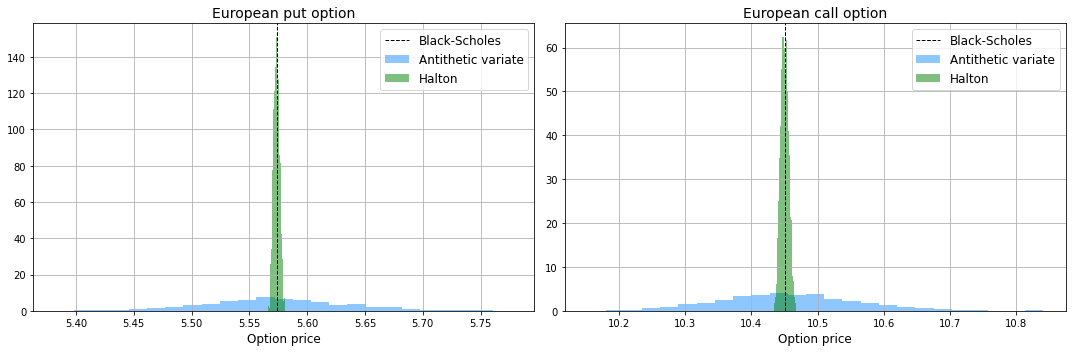

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(european_put_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[0].hist(european_put_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[0].axvline(BS_put_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[0].legend(fontsize = 12)
axes[0].grid()
axes[0].set_title('European put option', fontsize = 14)
axes[0].set_xlabel('Option price', fontsize = 12)
axes[1].hist(european_call_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[1].hist(european_call_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[1].axvline(BS_call_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[1].legend(fontsize = 12)
axes[1].grid()
axes[1].set_title('European call option', fontsize = 14)
axes[1].set_xlabel('Option price', fontsize = 12)
plt.tight_layout()
plt.show()

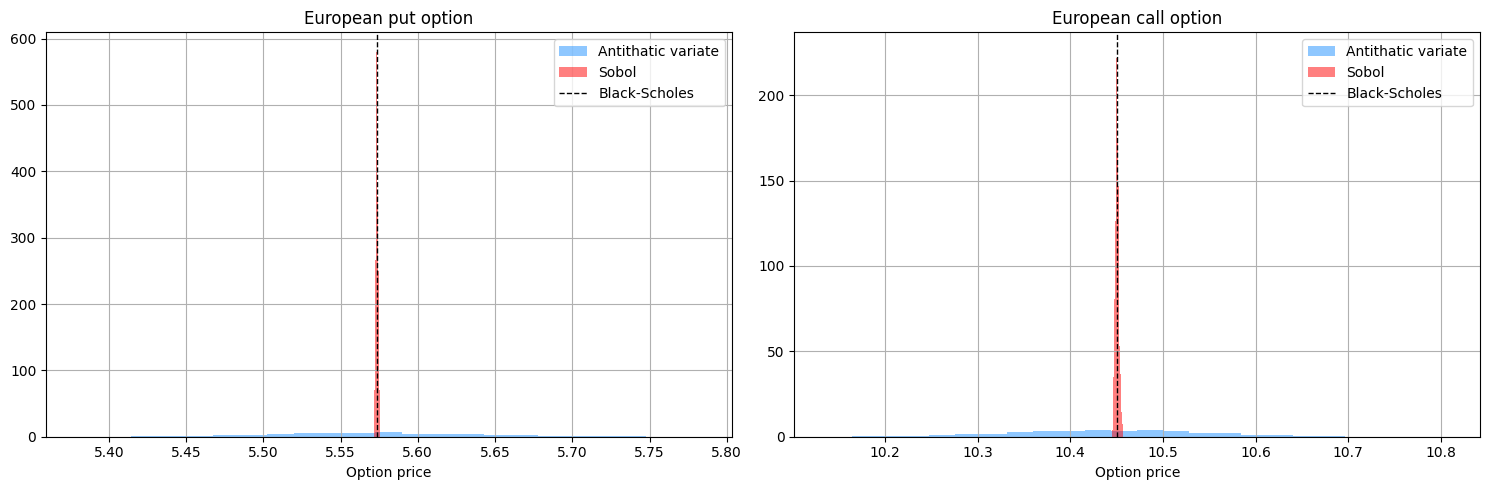

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(european_put_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[0].hist(european_put_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[0].axvline(BS_put_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[0].legend()
axes[0].grid()
axes[0].set_title('European put option')
axes[0].set_xlabel('Option price')
axes[1].hist(european_call_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[1].hist(european_call_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[1].axvline(BS_call_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[1].legend()
axes[1].grid()
axes[1].set_title('European call option')
axes[1].set_xlabel('Option price')
plt.tight_layout()
plt.show()

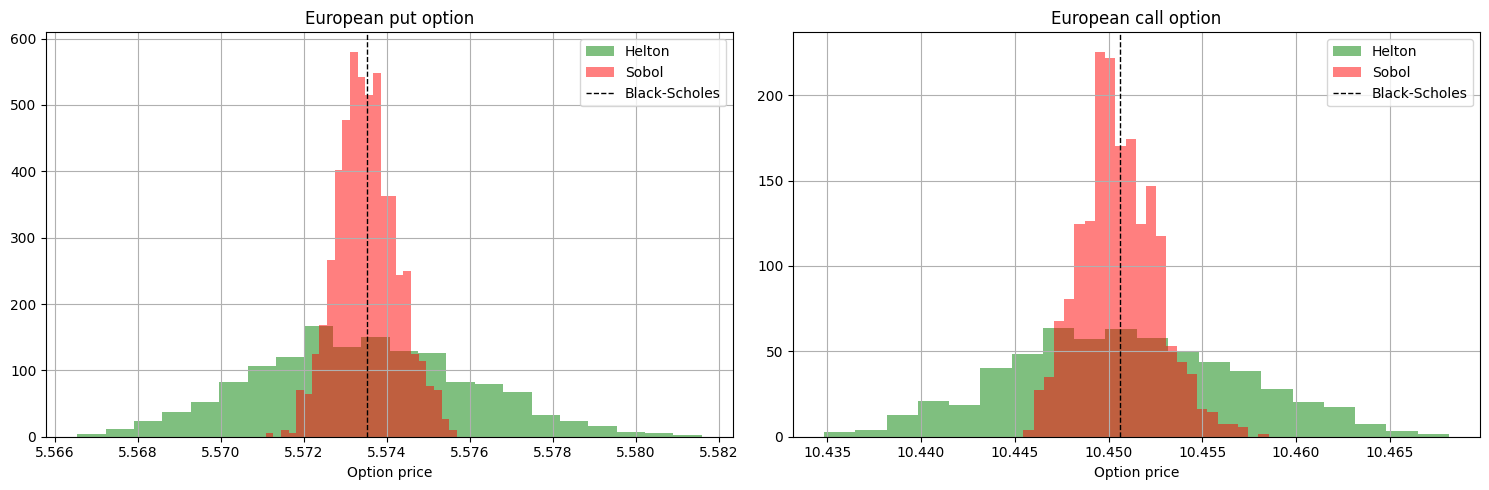

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(european_put_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[0].hist(european_put_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[0].axvline(BS_put_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[0].legend()
axes[0].grid()
axes[0].set_title('European put option')
axes[0].set_xlabel('Option price')
axes[1].hist(european_call_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[1].hist(european_call_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[1].axvline(BS_call_theo, color = 'black', label = 'Black-Scholes', lw = 1, linestyle = 'dashed')
axes[1].legend()
axes[1].grid()
axes[1].set_title('European call option')
axes[1].set_xlabel('Option price')
plt.tight_layout()
plt.show()

In [73]:
N_min_new = 2000
interval_new = 1000
N_max_new = 50000 + interval_new
steps = list(range(N_min_new, N_max_new, interval_new))

In [74]:
%%time

variance_european_halton_call= np.array([european_option_variance_halton(S_0, K, r, sigma, T, i, 'Call')
                                              for i in steps])
variance_european_halton_put = np.array([european_option_variance_halton(S_0, K, r, sigma, T, i, 'Put') 
                                                for i in steps])
variance_european_sobol_call = np.array([european_option_variance_sobol(S_0, K, r, sigma, T, i, 'Call')
                                              for i in steps])
variance_european_sobol_put = np.array([european_option_variance_sobol(S_0, K, r, sigma, T, i, 'Put') 
                                                for i in steps])
variance_european_anthitetic_variate_call = np.array([european_option_variance_antithetic_variate(S_0, K, r, sigma, T, i, 'Call') 
                                              for i in steps])
variance_european_anthitetic_variate_put = np.array([european_option_variance_antithetic_variate(S_0, K, r, sigma, T, i, 'Put')
                                                for i in steps])

CPU times: total: 4min 8s
Wall time: 4min 8s


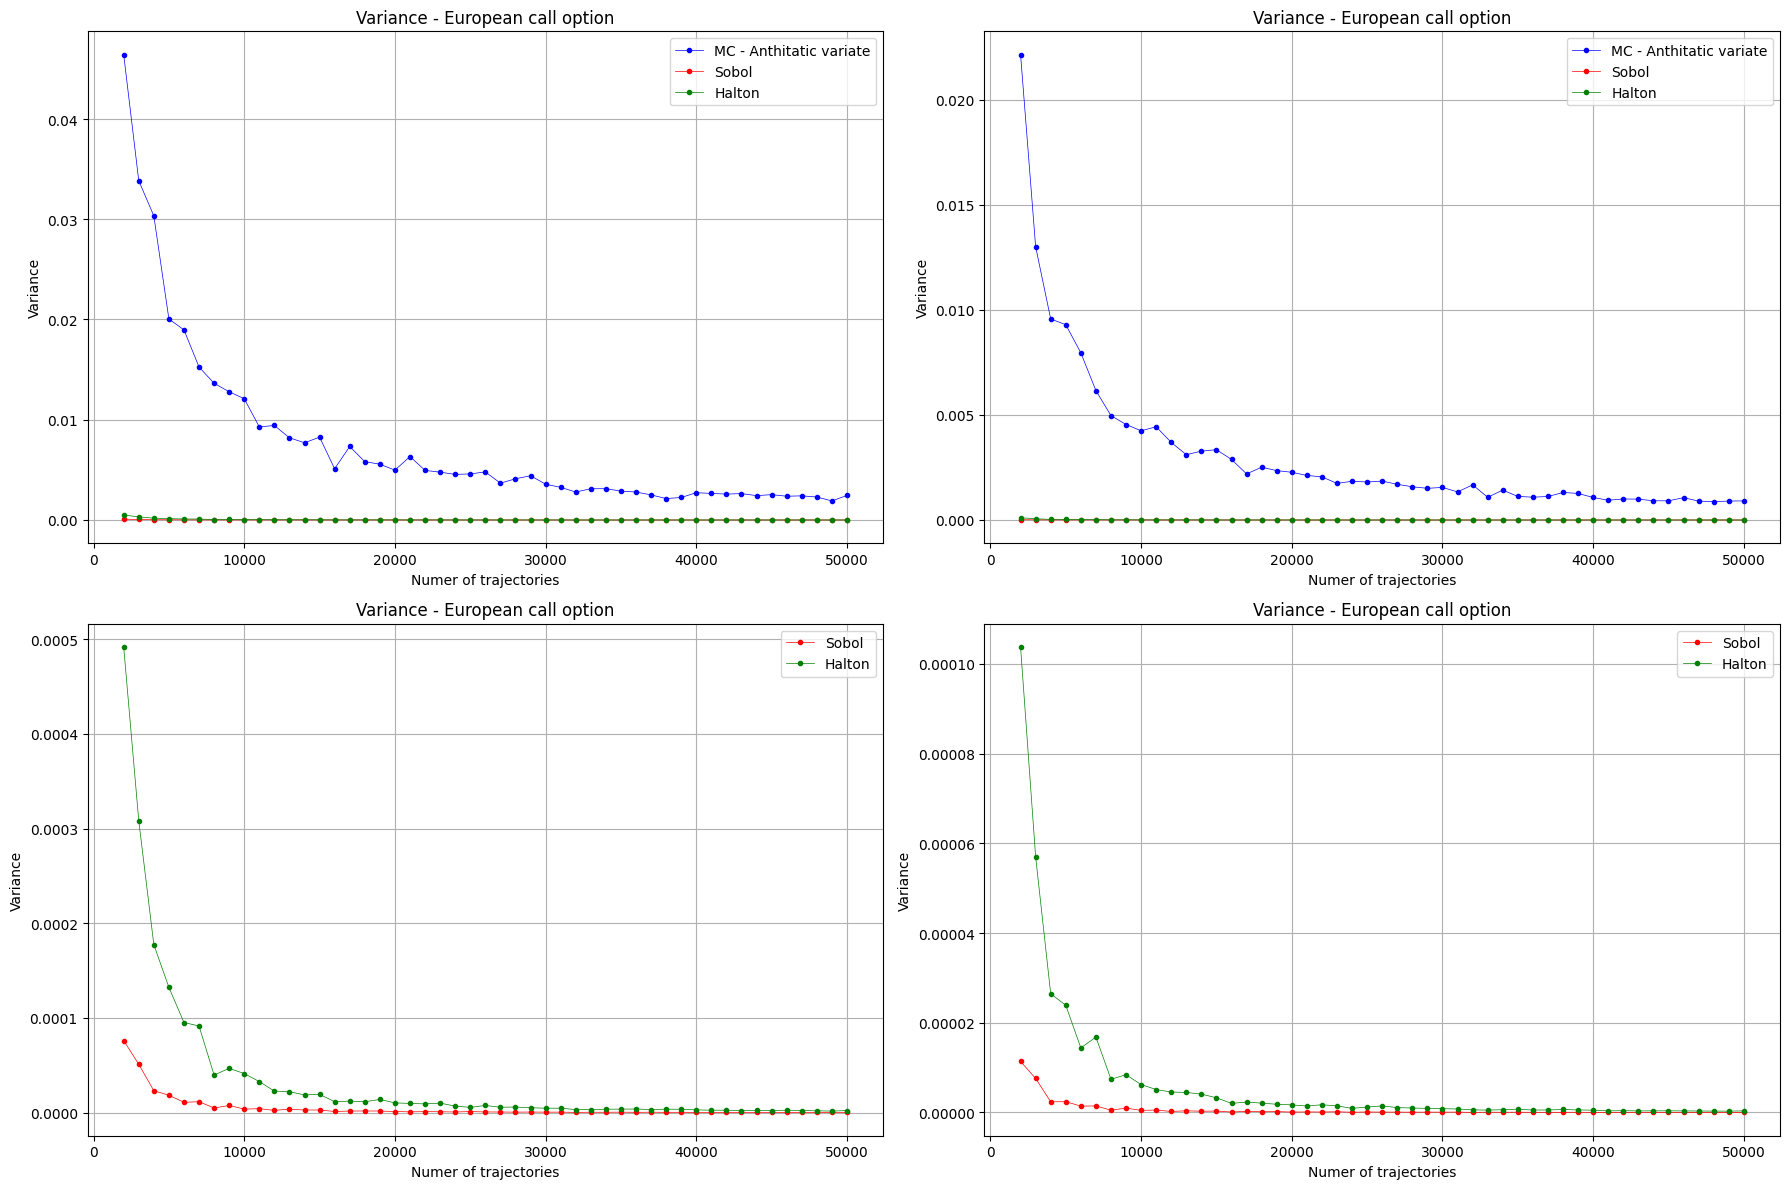

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(18,12))
axes[0,0].grid()
axes[0,0].plot(steps, variance_european_anthitetic_variate_call, lw = 0.5, label = 'MC - Anthitatic variate', color = 'blue', marker = '.')
axes[0,0].plot(steps, variance_european_sobol_call, lw = 0.5, label = 'Sobol', color = 'red', marker = '.')
axes[0,0].plot(steps, variance_european_halton_call, lw = 0.5, label = 'Halton', color = 'green', marker = '.')
axes[0,0].set_xlabel('Numer of trajectories')
axes[0,0].set_ylabel('Variance')
axes[0,0].set_title('Variance - European call option')
axes[0,0].legend()

axes[0,1].grid()
axes[0,1].plot(steps, variance_european_anthitetic_variate_put, lw = 0.5, label = 'MC - Anthitatic variate', color = 'blue', marker = '.')
axes[0,1].plot(steps, variance_european_sobol_put, lw = 0.5, label = 'Sobol', color = 'red', marker = '.')
axes[0,1].plot(steps, variance_european_halton_put, lw = 0.5, label = 'Halton', color = 'green', marker = '.')
axes[0,1].set_xlabel('Numer of trajectories')
axes[0,1].set_ylabel('Variance')
axes[0,1].set_title('Variance - European call option')
axes[0,1].legend()

axes[1,0].grid()
axes[1,0].plot(steps, variance_european_sobol_call, lw = 0.5, label = 'Sobol', color = 'red', marker = '.')
axes[1,0].plot(steps, variance_european_halton_call, lw = 0.5, label = 'Halton', color = 'green', marker = '.')
axes[1,0].set_xlabel('Numer of trajectories')
axes[1,0].set_ylabel('Variance')
axes[1,0].set_title('Variance - European call option')
axes[1,0].legend()

axes[1,1].grid()
axes[1,1].plot(steps, variance_european_sobol_put, lw = 0.5, label = 'Sobol', color = 'red', marker = '.')
axes[1,1].plot(steps, variance_european_halton_put, lw = 0.5, label = 'Halton', color = 'green', marker = '.')
axes[1,1].set_xlabel('Numer of trajectories')
axes[1,1].set_ylabel('Variance')
axes[1,1].set_title('Variance - European call option')
axes[1,1].legend()
plt.tight_layout()
plt.show()

# Asian opions

In [10]:
def asian_float_payoff(S, S_T, w ,option_type):
    if option_type == 'Call':
        payoff = np.maximum(S_T - w * S, 0)
    elif option_type == 'Put':
        payoff = np.maximum(w * S - S_T, 0)
    else:
        raise ValueError("Invalid option_type. Use 'Call' or 'Put'.")
    return payoff

In [11]:
def asian_option_price_QMC(S_0, K, r, sigma, T, k, N, option_type, sequence_type, w = 1):
    if sequence_type == 'Halton':
        halton_sample = stats.qmc.Halton(d = k+1, scramble = True).random(n = N)
        z = stats.norm.ppf(halton_sample)
    elif sequence_type == 'Sobol':
        halton_sample = stats.qmc.Sobol(d = k+1, scramble = True).random(n = N)
        z = stats.norm.ppf(halton_sample)      
    else:
        raise ValueError("Invalid sequence_type. Use 'Halton' or 'Sobol'.")
    time = np.arange(0, T + T/k, T/k)
    S_t = S_0 * np.exp((r - 0.5 * sigma**2) * time + sigma * np.sqrt(time) * z)
    ST = np.array([S_t[i][-1] for i in range(N)])
    S_t_average = np.mean(S_t, axis = 1)
    payoffs = asian_float_payoff(S_t_average, ST, w, option_type)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


def asian_option_price_MC(S_0, K, r, sigma, T, k, N, option_type, w = 1):
    z = np.random.normal(0, 1, size = [N, k+1])
    time = np.arange(0, T + T/k, T/k)
    S_t = S_0 * np.exp((r - 0.5 * sigma**2) * time + sigma * np.sqrt(time) * z)
    ST = np.array([S_t[i][-1] for i in range(N)])
    S_t_average = np.mean(S_t, axis = 1)
    payoffs = asian_float_payoff(S_t_average, ST, w, option_type)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


def asian_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, k, N, option_type, w = 1):
    z1 = np.random.normal(0, 1, size = [N//2, k+1])
    z2 = - z1
    time = np.arange(0, T + T/k, T/k)
    S_t_1 = S_0 * np.exp((r - 0.5 * sigma**2) * time + sigma * np.sqrt(time) * z1)
    S_t_2 = S_0 * np.exp((r - 0.5 * sigma**2) * time + sigma * np.sqrt(time) * z2)
    ST_1 = np.array([S_t_1[i][-1] for i in range(N//2)])
    ST_2 = np.array([S_t_2[i][-1] for i in range(N//2)])
    S_t_1_average = np.mean(S_t_1, axis = 1)
    S_t_2_average = np.mean(S_t_2, axis = 1)
    payoffs = 0.5 * (asian_float_payoff(S_t_1_average, ST_1, w, option_type) +  asian_float_payoff(S_t_2_average, ST_2, w, option_type))
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


def european_option_variance(S_0, K, r, sigma, T, N, option_type):
    prices = [european_option_price_MC(S_0, K, r, sigma, T, N, option_type)
                                          for _ in range(1000)]
    variance = np.var(prices)
    return variance

def european_option_variance_antithetic_variate(S_0, K, r, sigma, T, N, option_type):
    prices = np.array([european_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, N, option_type)
                                          for _ in range(1000)])
    variance = np.var(prices)
    return variance

In [12]:
N_min = 500
interval = 300
N_max = 50000 + interval
S_0 = 100
K = 100
T = 1
k = int(T*252)
sigma = 0.2
r = 0.05

In [13]:
numbers_of_steps = list(range(N_min, N_max, interval))

In [14]:
%%time
asian_put_prices_MC_antithetic_variate = [asian_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, k, i, 'Put') 
                                                            for i in numbers_of_steps]
asian_call_prices_MC_antithetic_variate = [asian_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, k, i, 'Call') 
                                           for i in numbers_of_steps]

CPU times: total: 1min 10s
Wall time: 1min 10s


In [15]:
%%time
asian_put_prices_QMC_Halton = [asian_option_price_QMC(S_0, K, r, sigma, T, k, i, 'Put', 'Halton')
                                              for i in numbers_of_steps]
asian_call_prices_QMC_Halton = [asian_option_price_QMC(S_0, K, r, sigma, T, k, i, 'Call', 'Halton')
                                                for i in numbers_of_steps]
asian_put_prices_QMC_Sobol = [asian_option_price_QMC(S_0, K, r, sigma, T, k, i, 'Put', 'Sobol')
                                              for i in numbers_of_steps]
asian_call_prices_QMC_Sobol = [asian_option_price_QMC(S_0, K, r, sigma, T, k, i, 'Call', 'Sobol')
                                                for i in numbers_of_steps]

CPU times: total: 6min 55s
Wall time: 6min 57s


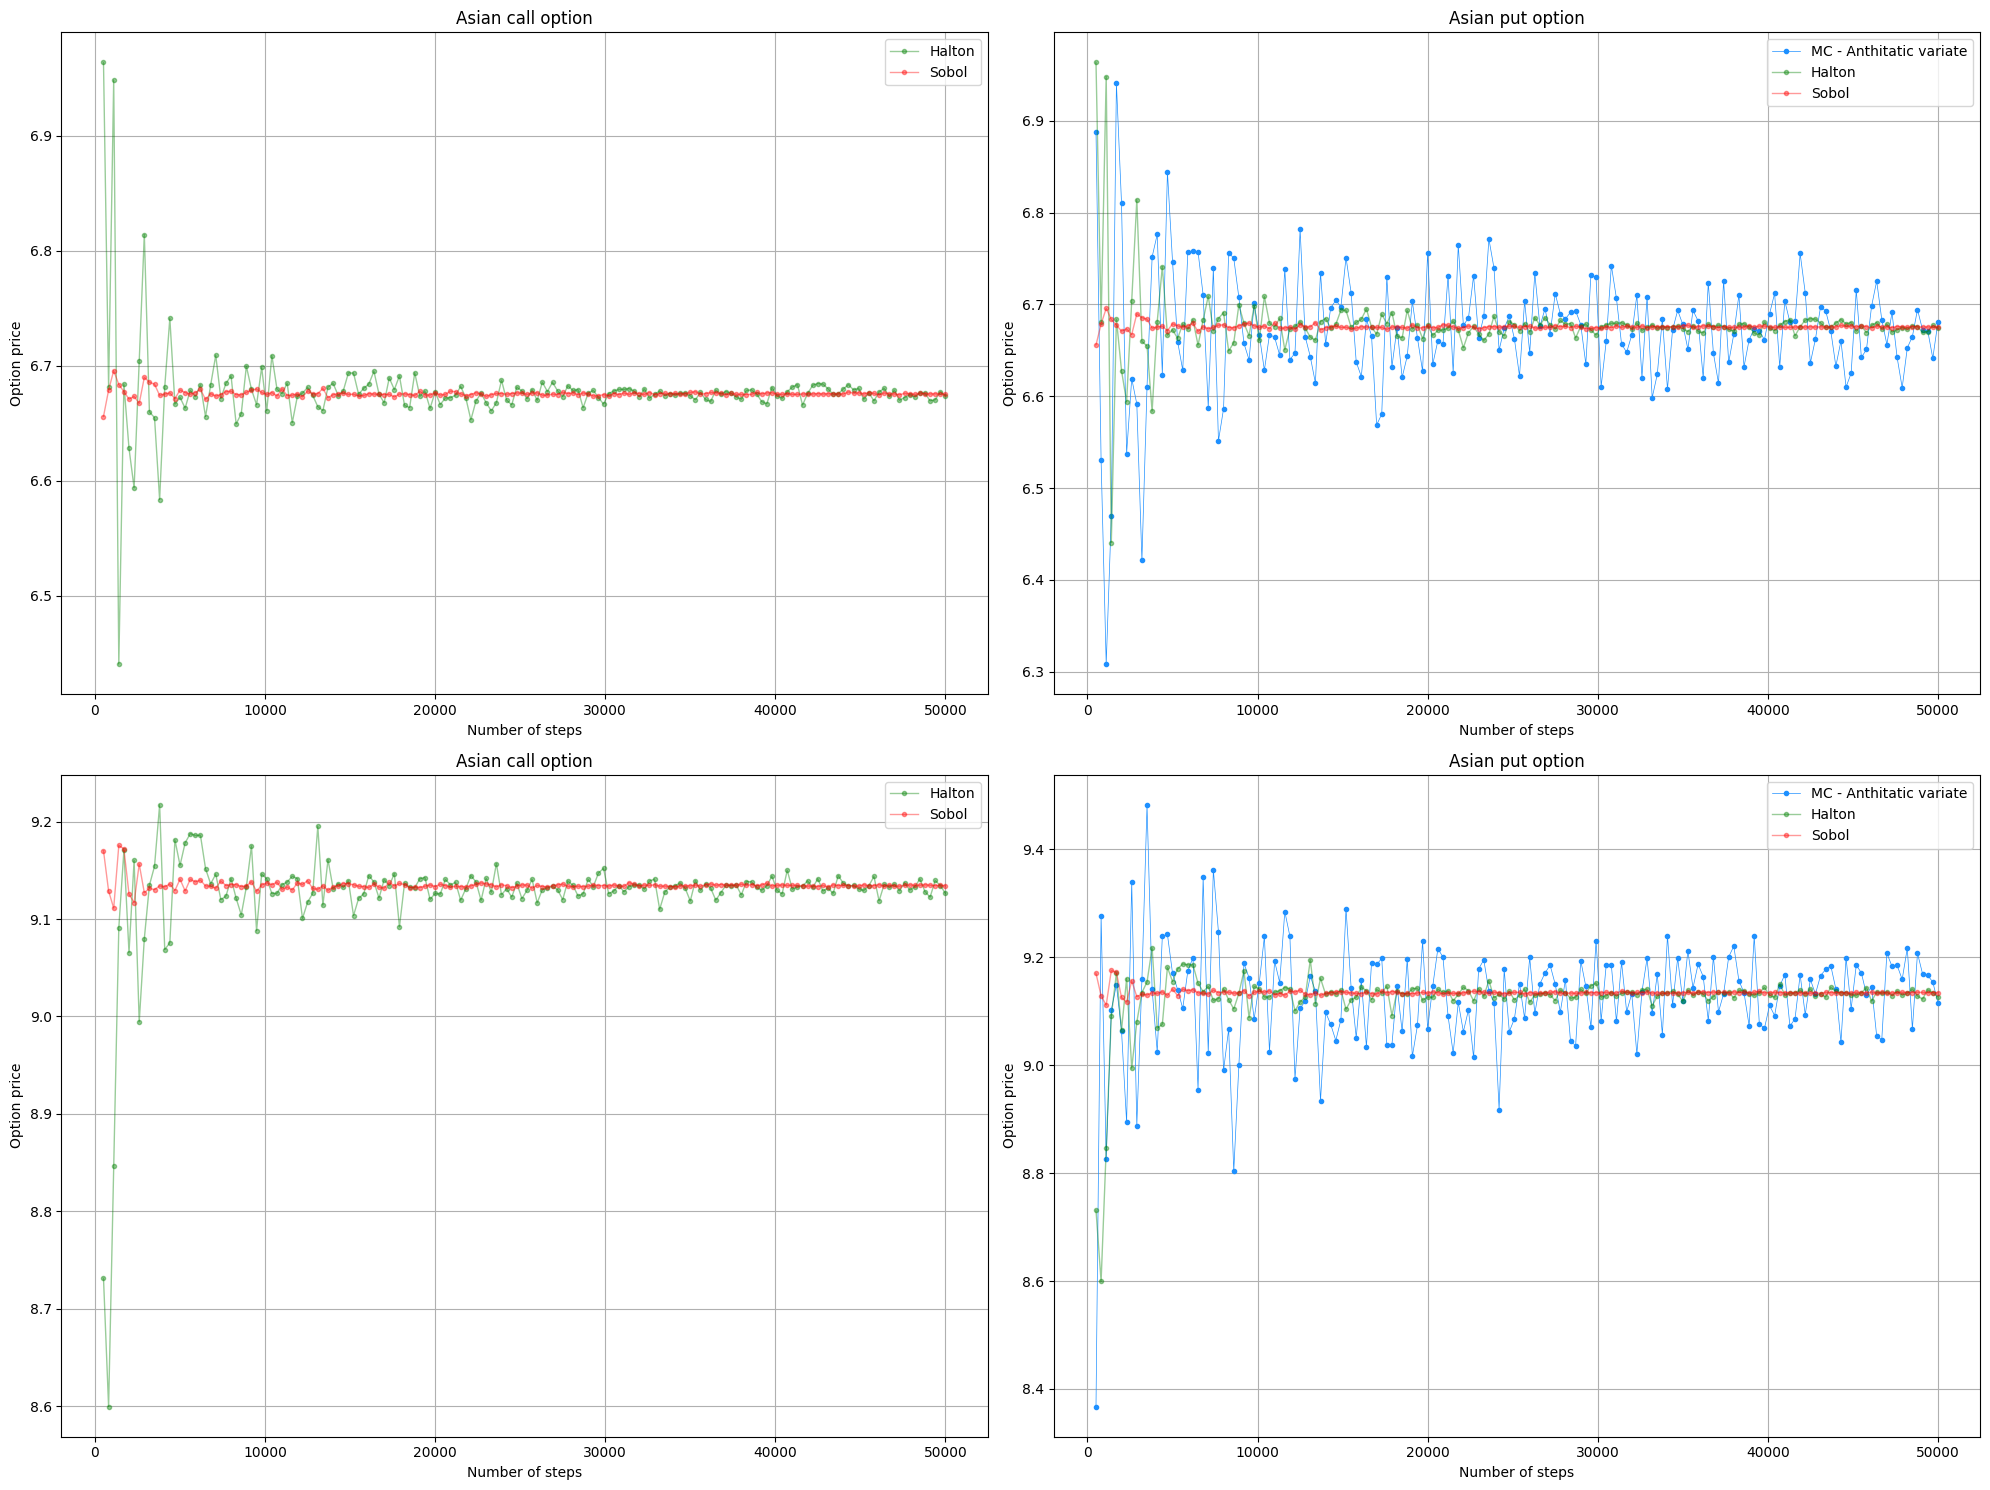

In [23]:
fig, axes = plt.subplots(2, 2,figsize=(20,15))
axes[0,0].grid()
axes[0,0].plot(numbers_of_steps, asian_put_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[0,0].plot(numbers_of_steps, asian_put_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[0,0].legend()
axes[0,0].set_title('Asian put option')
axes[0,0].set_ylabel('Option price')
axes[0,0].set_xlabel('Number of steps')
axes[1,0].grid()
axes[1,0].plot(numbers_of_steps, asian_call_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[1,0].plot(numbers_of_steps, asian_call_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[1,0].legend()
axes[1,0].set_title('Asian call option')
axes[1,0].set_ylabel('Option price')
axes[1,0].set_xlabel('Number of steps')
axes[0,1].grid()
axes[0,1].plot(numbers_of_steps, asian_put_prices_MC_antithetic_variate, lw = 0.5, color = 'dodgerblue', 
               label = 'MC - Anthitetic variate', marker = '.')
axes[0,1].plot(numbers_of_steps, asian_put_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[0,1].plot(numbers_of_steps, asian_put_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[0,1].legend()
axes[0,1].set_title('Asian put option')
axes[0,1].set_ylabel('Option price')
axes[0,1].set_xlabel('Number of steps')
axes[1,1].grid()
axes[1,1].plot(numbers_of_steps, asian_call_prices_MC_antithetic_variate, lw = 0.5, color = 'dodgerblue', 
               label = 'MC - Anthitetic variate', marker = '.')
axes[1,1].plot(numbers_of_steps, asian_call_prices_QMC_Halton, lw = 1, label = 'Halton', alpha = 0.4, color = 'green', marker = '.')
axes[1,1].plot(numbers_of_steps, asian_call_prices_QMC_Sobol, lw = 1, label = 'Sobol', alpha = 0.4, color = 'red', marker = '.')
axes[1,1].legend()
axes[1,1].set_title('Asian call option')
axes[1,1].set_ylabel('Option price')
axes[1,1].set_xlabel('Number of steps')
plt.tight_layout()
plt.show()

In [39]:
%%time
asian_put_prices_MC_antithetic_variate_hist = [asian_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, k, 10000, 'Put')
                                          for _ in range(1000)]
asian_call_prices_MC_antithetic_variate_hist = [asian_option_price_MC_antithetic_variate(S_0, K, r, sigma, T, k, 10000, 'Call') 
                                            for _ in range(1000)]
asian_put_prices_QMC_halton_hist = [asian_option_price_QMC(S_0, K, r, sigma, T, k, 10000, 'Put', 'Halton') 
                                          for _ in range(1000)]
asian_call_prices_QMC_halton_hist = [asian_option_price_QMC(S_0, K, r, sigma, T, k, 10000, 'Call', 'Halton')
                                            for _ in range(1000)]
asian_put_prices_QMC_sobol_hist = [asian_option_price_QMC(S_0, K, r, sigma, T, k, 10000, 'Put', 'Sobol') 
                                          for _ in range(1000)]
asian_call_prices_QMC_sobol_hist = [asian_option_price_QMC(S_0, K, r, sigma, T, k, 10000, 'Call', 'Sobol')
                                            for _ in range(1000)]

CPU times: total: 20min 43s
Wall time: 21min 12s


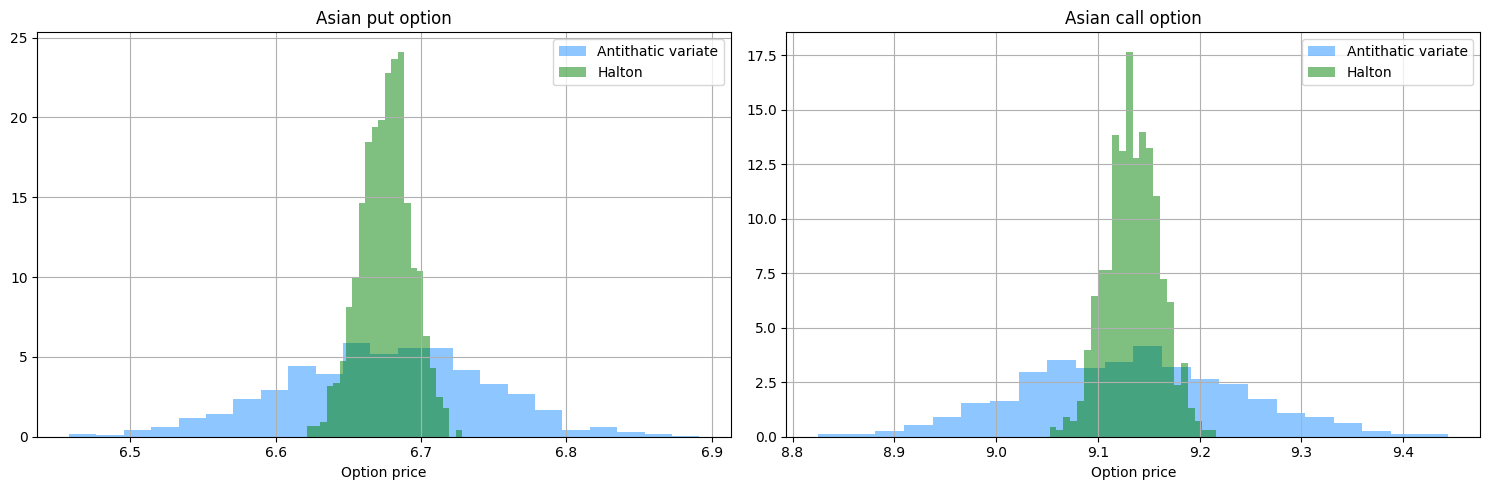

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(asian_put_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[0].hist(asian_put_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Asian put option')
axes[0].set_xlabel('Option price')
axes[1].hist(asian_call_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[1].hist(asian_call_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Asian call option')
axes[1].set_xlabel('Option price')
plt.tight_layout()
plt.show()

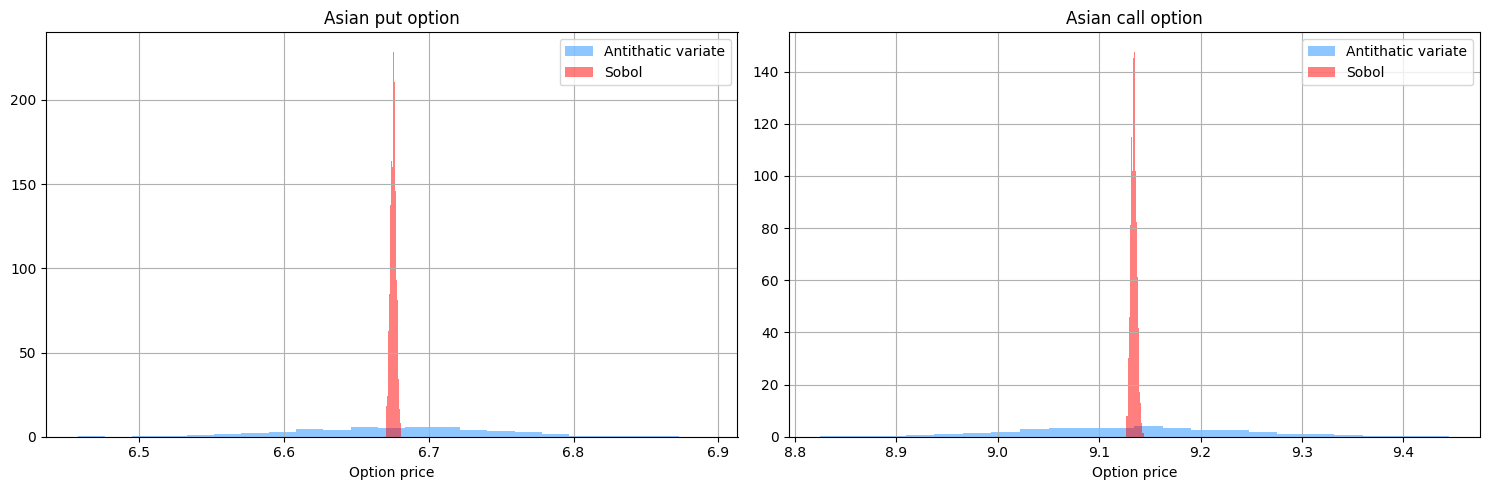

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(asian_put_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[0].hist(asian_put_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Asian put option')
axes[0].set_xlabel('Option price')
axes[1].hist(asian_call_prices_MC_antithetic_variate_hist, bins = 'auto', density = True, alpha = 0.5, label = 'Antithetic variate', 
             color = 'dodgerblue')
axes[1].hist(asian_call_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[1].grid()
axes[1].set_title('Asian call option')
axes[1].set_xlabel('Option price')
axes[1].legend()
plt.tight_layout()
plt.show()

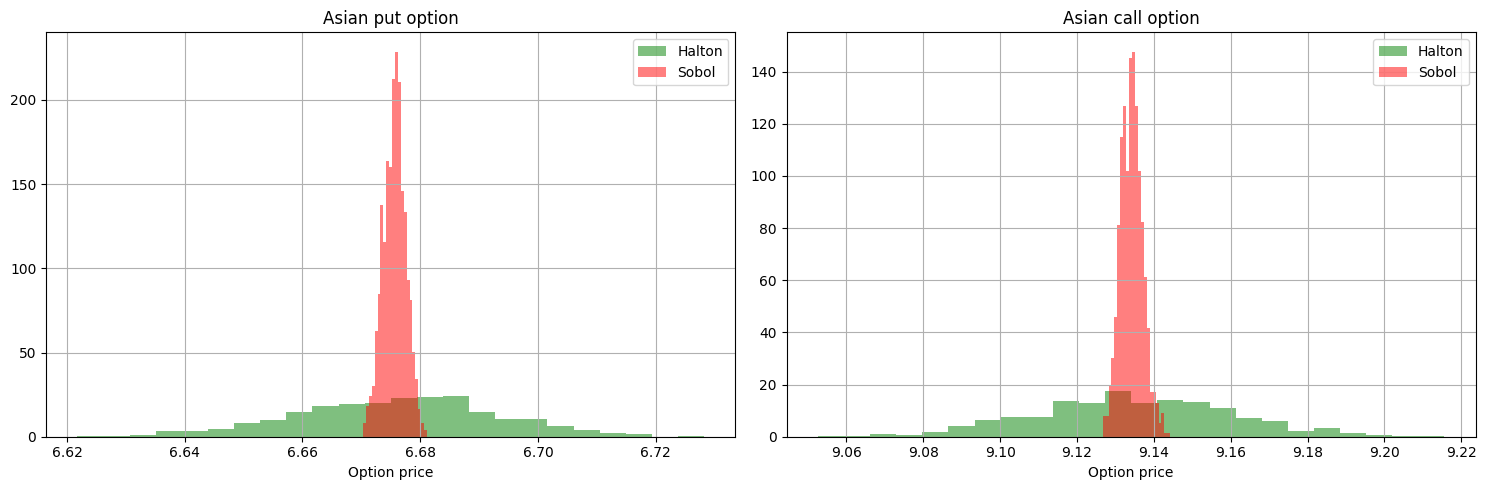

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(asian_put_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[0].hist(asian_put_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Asian put option')
axes[0].set_xlabel('Option price')
axes[1].hist(asian_call_prices_QMC_halton_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Halton', color = 'green')
axes[1].hist(asian_call_prices_QMC_sobol_hist, bins = 'auto', density = True, alpha = 0.5,  label = 'Sobol', color = 'red')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Asian call option')
axes[1].set_xlabel('Option price')
plt.tight_layout()
plt.show()